# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

In [4]:
from sklearn import metrics 
from metrics import mean_squared_error
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared = False)

ModuleNotFoundError: No module named 'metrics'

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [164]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [165]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [166]:
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [167]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [168]:
df.value_counts()

age  job         marital   education  default  balance        housing  loan  contact    day  month  duration  campaign  pdays  previous  poutcome  deposit
18   student     single    primary    no        608,00 $      no       no    cellular   12   aug    267       1         -1     0         unknown   yes        1
45   management  single    tertiary   no        4 831,00 $    no       no    cellular   30   jul    852       3          182   11        success   yes        1
                 married   tertiary   yes      -577,00 $      yes      yes   cellular   24   jul    204       1         -1     0         unknown   no         1
                           unknown    no        2 724,00 $    no       no    cellular   28   jun    359       2          182   1         success   yes        1
                                                9 051,00 $    yes      no    unknown    19   may    124       63        -1     0         unknown   no         1
                                             

### Задание 3

In [169]:
df['balance'].head(15)

0      2 343,00 $ 
1         45,00 $ 
2      1 270,00 $ 
3      2 476,00 $ 
4        184,00 $ 
5            0  $ 
6        830,00 $ 
7        545,00 $ 
8          1,00 $ 
9              NaN
10       100,00 $ 
11       309,00 $ 
12       199,00 $ 
13       460,00 $ 
14       703,00 $ 
Name: balance, dtype: object

In [170]:
def to_float(x):
    x = str(x)
    x = x.replace(' ', '').replace(',00', '').replace('$', '')
    return x

In [171]:
df['balance'] = df['balance'].apply(to_float).astype('float')

In [172]:
print(round(df['balance'].mean(), 3))


1529.129


### Задание 4

In [173]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df = df.fillna({'balance':df['balance'].median()})

In [174]:
df['balance']

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

In [175]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [176]:
print(round(df['balance'].mean(), 3))

1526.936


### Задание 5

In [177]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код


In [178]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [179]:
df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [180]:
df['job'] = df['job'].apply(lambda x: 'management' if x == 'unknown' else x)

In [181]:
df['education'] = df['education'].apply(lambda x: 'secondary' if x == 'unknown' else x)

In [182]:
mask = (df['job']=='management')&(df['education']=='secondary')
print(round(df[mask]['balance'].mean(), 3))

1598.883


### Задание 6

In [183]:
# удалите все выбросы для признака balance
# ваш код

In [184]:
def outliers_iqr(data, feature):
    x = data[feature]
    quart1, quart3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quart3-quart1
    low_bound = quart1-(iqr*1.5)
    up_bound = quart3+(iqr*1.5)
    print(low_bound, up_bound)
    outliers = data[(x<low_bound)|(x>up_bound)]
    cleaned = data[(x>=low_bound)&(x<=up_bound)]
    return outliers, cleaned

In [185]:
outliers, cleaned = outliers_iqr(df, 'balance')

-2241.0 4063.0


In [186]:
cleaned.shape

(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1

In [187]:
cleaned[cleaned['deposit']=='yes']['deposit'].count()

4681

In [188]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте
cleaned['deposit'].value_counts(normalize=True)

no     0.536764
yes    0.463236
Name: deposit, dtype: float64

<AxesSubplot: xlabel='deposit', ylabel='count'>

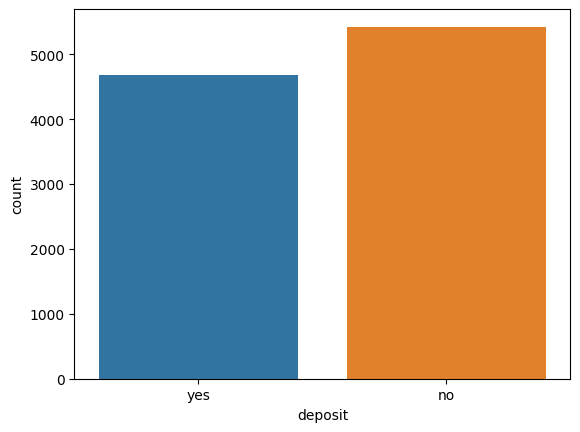

In [189]:
sns.countplot(cleaned, x='deposit')

### Задания 2 и 3

In [190]:
cleaned.head(20)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
5,42,management,single,tertiary,no,0.0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
6,56,management,married,tertiary,no,830.0,yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes
7,60,retired,divorced,secondary,no,545.0,yes,no,unknown,6,may,1030,1,-1,0,unknown,yes
8,37,technician,married,secondary,no,1.0,yes,no,unknown,6,may,608,1,-1,0,unknown,yes
9,28,services,single,secondary,no,550.0,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes


In [191]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


In [192]:
cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [193]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

### Задания 4 и 5

In [194]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

In [195]:
cleaned.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


### Задание 6

In [196]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

In [197]:
cleaned['poutcome'].value_counts()

unknown    7570
failure    1109
success     945
other       481
Name: poutcome, dtype: int64

<AxesSubplot: xlabel='poutcome'>

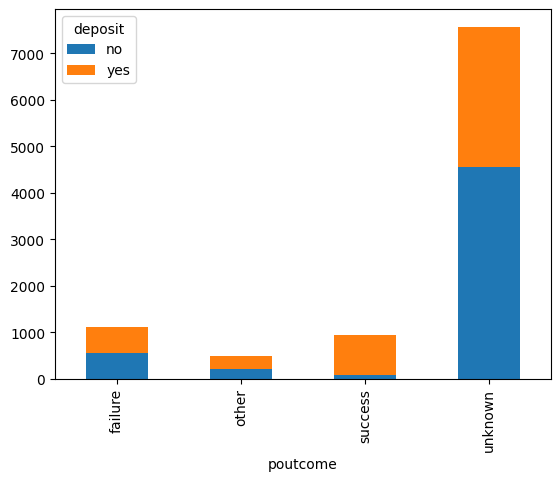

In [198]:
types = cleaned.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

### Задание 7

In [199]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

<AxesSubplot: xlabel='month'>

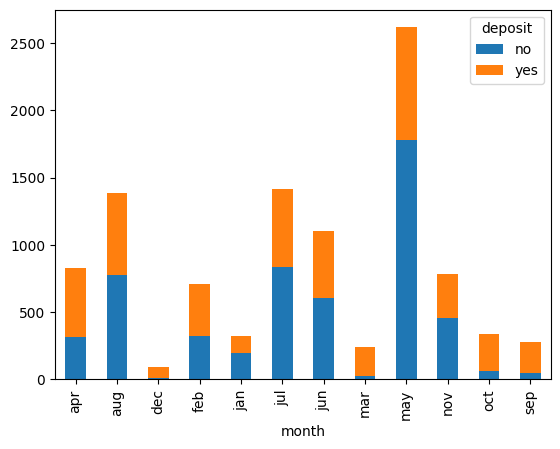

In [200]:
types = cleaned.groupby("month")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

### Задание 8

In [201]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

<AxesSubplot: xlabel='age_group', ylabel='count'>

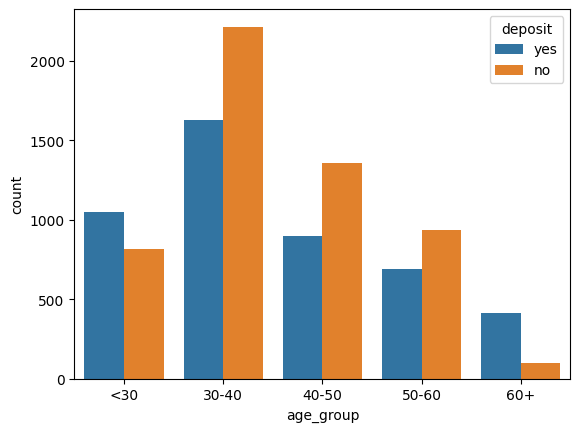

In [204]:

cleaned['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=cleaned)

### Задания 9 и 10

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

<AxesSubplot: xlabel='count', ylabel='marital'>

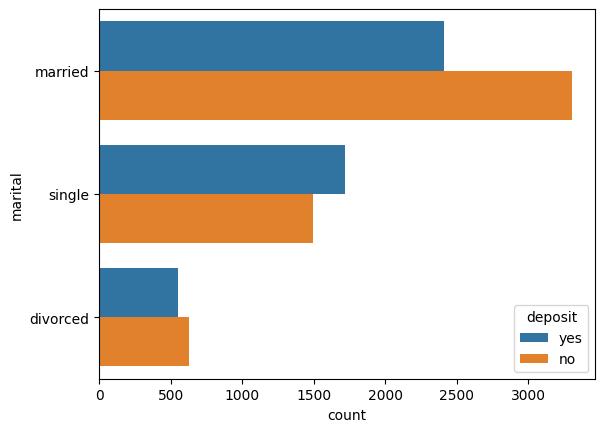

In [205]:
sns.countplot(y='marital', hue='deposit', data=cleaned)

In [206]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

<AxesSubplot: xlabel='count', ylabel='education'>

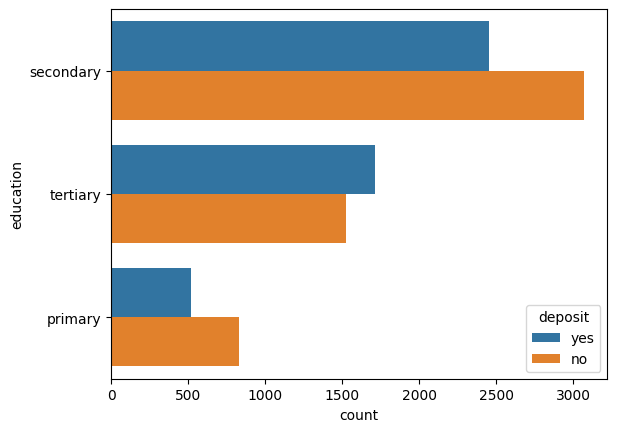

In [207]:
sns.countplot(y='education', hue='deposit', data=cleaned)

In [208]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

<AxesSubplot: xlabel='count', ylabel='job'>

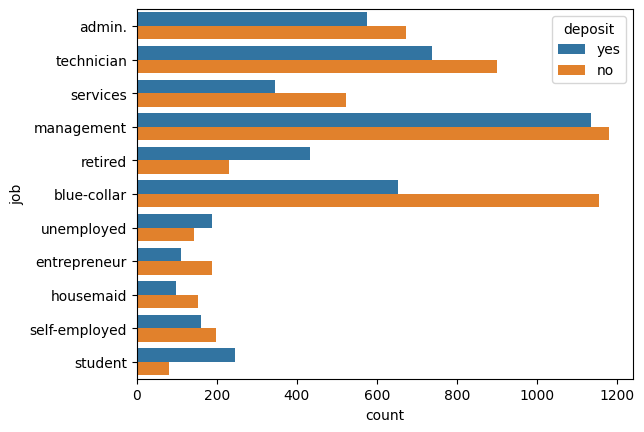

In [209]:
sns.countplot(y='job', hue='deposit', data=cleaned)

### Задание 11

In [210]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

In [211]:
dep_yes_df = cleaned[cleaned['deposit']=='yes']
dep_no_df = cleaned[cleaned['deposit']=='no']

In [212]:
dep_yes = dep_yes_df.pivot_table(values='deposit', index='education', columns='marital', aggfunc='count', fill_value=0)
dep_yes

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


<AxesSubplot: xlabel='marital', ylabel='education'>

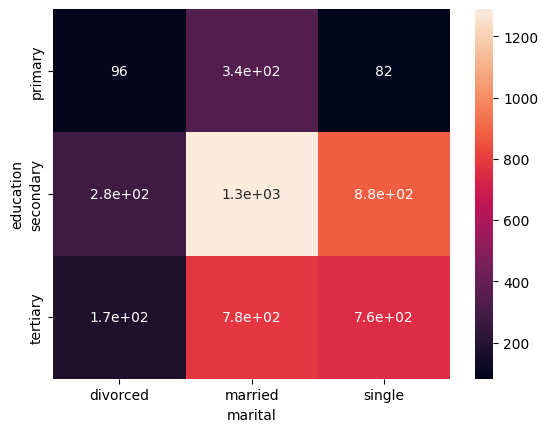

In [213]:
sns.heatmap(dep_yes, annot=True)

## Часть 3: преобразование данных

### Задание 1

In [214]:
# преобразуйте уровни образования
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
cleaned['education'] = lab_enc.fit_transform(cleaned['education'])
cleaned['education'].sum()

11995

In [215]:
cleaned['age_group'] = lab_enc.fit_transform(cleaned['age_group'])
cleaned['age_group'].sum()

14524

In [216]:
cleaned.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,2
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,2


### Задания 2 и 3

In [236]:
# преобразуйте бинарные переменные в представление из нулей и единиц
cleaned['deposit'] = cleaned['deposit'].apply(lambda x: 1 if x=='yes' else 0)
cleaned['housing'] = cleaned['housing'].apply(lambda x: 1 if x=='yes' else 0)
cleaned['default'] = cleaned['default'].apply(lambda x: 1 if x=='yes' else 0)
cleaned['loan'] = cleaned['loan'].apply(lambda x: 1 if x=='yes' else 0)

In [239]:
round((cleaned['default'].mean()+cleaned['housing'].mean()+cleaned['loan'].mean()),3)

0.635

In [238]:
cleaned.describe()


,age,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,deposit,age_group
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,1.187036,0.016428,807.653538,0.481148,0.137853,15.590302,368.742603,2.517170,51.319644,0.816230,0.463236,1.437308
std,11.734931,0.647373,0.127119,994.151966,0.499669,0.344762,8.441510,346.651524,2.707159,109.644179,2.243795,0.498671,1.489490
min,18.000000,0.000000,0.000000,-2049.000000,0.000000,0.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
25%,32.000000,1.000000,0.000000,95.000000,0.000000,0.000000,8.000000,137.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
50%,38.000000,1.000000,0.000000,445.000000,0.000000,0.000000,15.000000,252.000000,2.000000,-1.000000,0.000000,0.000000,1.000000
75%,48.000000,2.000000,0.000000,1227.000000,1.000000,0.000000,22.000000,490.000000,3.000000,2.000000,1.000000,1.000000,2.000000
max,95.000000,2.000000,1.000000,4063.000000,1.000000,1.000000,31.000000,3881.000000,43.000000,854.000000,58.000000,1.000000,4.000000


In [237]:
cleaned.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2


### Задание 4

In [242]:
# создайте дамми-переменные
data = pd.get_dummies(cleaned, columns=['job','marital','contact','month','poutcome'])
data

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,56,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,55,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,54,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,0,0,1.0,1,0,20,257,1,-1,...,0,0,0,0,0,0,0,0,0,1
11158,39,1,0,733.0,0,0,16,83,4,-1,...,1,0,0,0,0,0,0,0,0,1
11159,32,1,0,29.0,0,0,19,156,2,-1,...,0,0,0,0,0,0,0,0,0,1
11160,43,1,0,0.0,0,1,8,9,2,172,...,0,0,1,0,0,0,1,0,0,0


In [244]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int32  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задания 5 и 6

In [251]:
import plotly.express as px

px.imshow(data.corr(),  height=1200, width=1200)

### Задания 7 и 8

In [252]:
X = data.drop(['deposit'], axis=1)
y = data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [253]:
# рассчитайте необходимые показатели
X_test.shape

(3335, 45)

In [254]:
y_test.mean()

0.46326836581709147

### Задание 9

In [222]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

In [258]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
selector.get_feature_names_out()
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

### Задание 10

In [259]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_sel)                           # fit() только на train данных
X_train_scaled = scaler.transform(X_train_sel)    # fransform() на train данных
X_test_scaled = scaler.transform(X_test_sel)      # fransform() на test данных

print(X_test_scaled[:, 0].mean())  # для признака balance, обратите внимание именно на столбец

0.46823674223097866


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [261]:

log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)
print(metrics.classification_report(y_test, log_reg.predict(X_test_scaled)))
# обучите логистическую регрессию и рассчитайте метрики качества

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4

In [263]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)

dt.fit(X_train_scaled, y_train)
print(metrics.classification_report(y_test, dt.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

In [267]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(), 
                        parameters,
                        cv=3, scoring=('f1'), 
                        return_train_score=True)

model_cv.fit(X_train_scaled, y_train)
print(model_cv.best_params_)
print(model_cv.best_estimator_)
print(model_cv.best_score_)

{'max_depth': 7, 'min_samples_split': 10}
DecisionTreeClassifier(max_depth=7, min_samples_split=10)
0.7958677861339178


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [274]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)
print(metrics.classification_report(y_test, rf.predict(X_test_scaled)))
print(metrics.recall_score(y_test, rf.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

0.8330097087378641


### Задания 2 и 3

In [273]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

print(metrics.classification_report(y_test, gb.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [275]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       min_samples_leaf=5,
                                                       random_state=42)),
                               ('log_reg',
                                LogisticRegression(random_state=42,
                                                   solver='sag')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [280]:
y_pred = stack.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

0.8099547511312217


### Задание 5

In [230]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [283]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

In [284]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [285]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-04-27 14:44:03,267] A new study created in memory with name: RandomForestClassifier
[I 2023-04-27 14:44:04,629] Trial 0 finished with value: 0.8624024960998439 and parameters: {'n_estimators': 147, 'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8624024960998439.
[I 2023-04-27 14:44:05,576] Trial 1 finished with value: 0.8503986243551666 and parameters: {'n_estimators': 122, 'max_depth': 27, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8624024960998439.
[I 2023-04-27 14:44:06,649] Trial 2 finished with value: 0.8446052217678515 and parameters: {'n_estimators': 151, 'max_depth': 10, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8624024960998439.
[I 2023-04-27 14:44:07,517] Trial 3 finished with value: 0.8441435768261965 and parameters: {'n_estimators': 113, 'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8624024960998439.
[I 2023-04-27 14:44:09,174] Trial 4 finished with value: 0.8880900281337918 and parameters: {'n

CPU times: total: 30.2 s
Wall time: 30.8 s


In [286]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 198, 'max_depth': 17, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.91


In [287]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)

y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.82


In [288]:
print(metrics.accuracy_score(y_test, y_test_pred))

0.8275862068965517
